In [225]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import yfinance as yf
from backtesting import Backtest, Strategy
import numpy as np

Get Stock Data from Yahoo Finance

In [279]:
ticker = ["^GSPC"]

temp = yf.download(ticker, start = "2000-01-01", end = "2025-01-01", group_by="ticker")

GSPC = temp["^GSPC"].drop(['Volume'], axis = 1)

[*********************100%***********************]  1 of 1 completed


# DCA Strategy

In [258]:
pd.set_option('display.float_format', '{:.2f}'.format)

monthly_investment = 1000

monthly_open = GSPC['Open'].resample('MS').first()

monthly_trades = pd.DataFrame({'Open Price': monthly_open,})

monthly_trades['Investment'] = monthly_investment
monthly_trades['Shares_Bought'] = monthly_trades['Investment'] / monthly_trades['Open Price']
monthly_trades['Cumul_Shares'] = monthly_trades['Shares_Bought'].cumsum()
monthly_trades['Cumul_Invested'] = monthly_trades['Investment'].cumsum()

monthly_close = GSPC['Close'].resample('MS').last()  # Get the last closing price of each month
monthly_trades['Portfolio Value'] = monthly_trades['Cumul_Shares'] * monthly_close


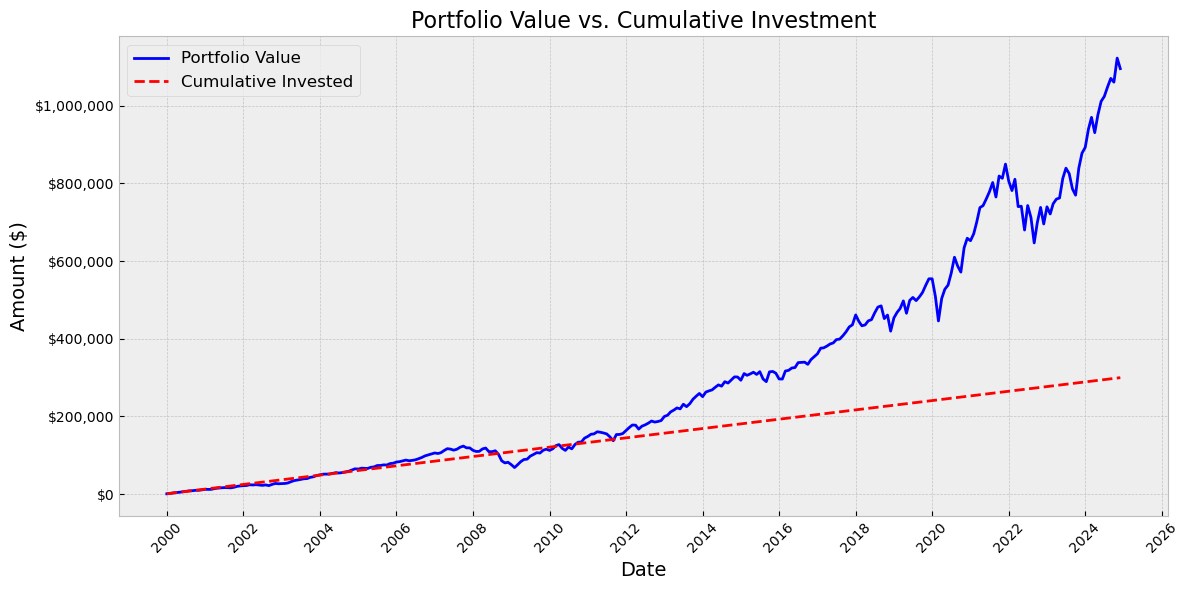

In [245]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the portfolio value
ax.plot(
    plot_data.index,
    plot_data['Portfolio Value'],
    'b-',
    linewidth=2,
    label='Portfolio Value'
)

# Plot the cumulative invested capital
ax.plot(
    plot_data.index,
    monthly_trades.loc[plot_data.index, 'Cumul_Invested'],
    'r--',
    linewidth=2,
    label='Cumulative Invested'
)

# Format the plot
ax.set_title('Portfolio Value vs. Cumulative Investment', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Amount ($)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))
plt.xticks(rotation=45)

# Format y-axis to show dollar amounts
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x)))
)

# Add legend
ax.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


# SMA Crossover Strategy

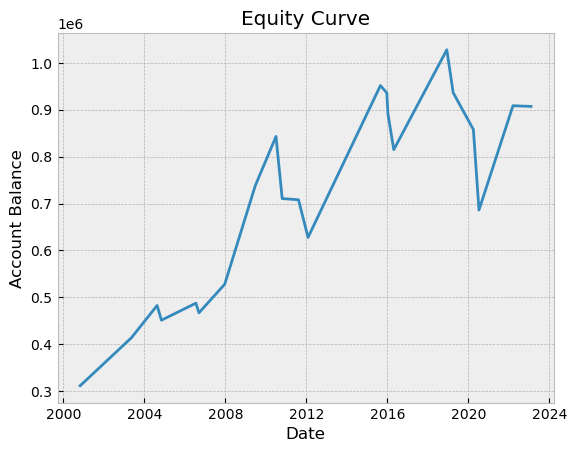

,Entry Date,Position,Entry Price,Exit Date,Exit Price,Return,Balance After Trade
0,2000-01-03,short,1455.22,2000-10-30,1398.66,3.89,311660.08
1,2000-10-30,short,1398.66,2003-05-14,939.28,32.84,414022.63
2,2003-05-14,long,939.28,2004-08-18,1095.17,16.60,482736.96
3,2004-08-18,short,1095.17,2004-11-05,1166.17,-6.48,451441.06
4,2004-11-05,long,1166.17,2006-07-19,1259.81,8.03,487690.45
5,2006-07-19,short,1259.81,2006-09-12,1313.00,-4.22,467099.86
6,2006-09-12,long,1313.00,2007-12-21,1484.46,13.06,528096.76
7,2007-12-21,short,1484.46,2009-06-23,895.10,39.70,737761.63
8,2009-06-23,long,895.10,2010-07-02,1022.58,14.24,842833.56
9,2010-07-02,short,1022.58,2010-10-22,1183.08,-15.70,710545.88


In [321]:
GSPC["SMA_50"] = GSPC['Close'].rolling(window = 50).mean().dropna()
GSPC["SMA_200"] = GSPC['Close'].rolling(window = 200).mean().dropna()

# Got this section of code from https://stackoverflow.com/questions/28345261/python-and-pandas-moving-average-crossover

diff         = GSPC['SMA_50'] < GSPC['SMA_200']
diff_forward = diff.shift(1)
crossing     = np.where(diff != diff_forward)[0]

# 2) Build signals
signals = []
for i in crossing:
    if GSPC['SMA_50'].iloc[i] > GSPC['SMA_200'].iloc[i]:
        signals.append((i, 'long'))   # Golden cross → go long
    else:
        signals.append((i, 'short'))  # Death cross → go short

# 3) Backtest loop
initial_balance = 300000 # Using 300k as we invsted that same amount in the DCA Model
balance = initial_balance
equity_times = []
equity_values = []
trades = []

# Loop through each crossover 

for j in range(len(signals) - 1):
    entry_id, position = signals[j]
    exit_id, _     = signals[j + 1]
    
    entry_price = GSPC['Close'].iloc[entry_id]
    exit_price  = GSPC['Close'].iloc[exit_id]
    
    if position == 'long':
        Return = (exit_price - entry_price) / entry_price
    else:
        Return = (entry_price - exit_price) / entry_price
    
    profit = balance * Return
    balance += profit
    
    equity_times.append(GSPC.index[exit_id])
    equity_values.append(balance)
    
    trades.append({
        'Entry Date': GSPC.index[entry_id],
        'Position'      : position,
        'Entry Price': entry_price,
        'Exit Date' : GSPC.index[exit_id],
        'Exit Price': exit_price,
        'Return'    : Return * 100,
        'Balance After Trade': balance
    })

trades_df = pd.DataFrame(trades)

# Plot the equity curve
plt.figure()
plt.plot(equity_times, equity_values)
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Account Balance')
plt.show()

# Display detailed trade log
trades_df
